In [53]:
from pathlib import Path
from skimage import io
import skimage
import numpy as np
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2

In [217]:
from numba import njit

In [8]:
data_dir = Path('/home/jupyter/scratch/projects/023/01_data/cropped/A/objects/')

In [166]:
annotations = pd.read_csv('/scratch/projects/023/01_data/cropped/grana_20231028.csv')
annotations = annotations.loc[annotations['readable']].reindex()
annotations['period'] = annotations['period'].astype('float')
annotations['granum_lumen_fraction'] = annotations['granum_lumen_fraction'].astype('float')
annotations.head()

,object_filename,image_filename,object_idx,angle,hight,diameter_min,diameter_max,diameter_mean,layers_lumnen_fraction,granum_lumen_fraction,layers_number,period,readable_code,readable
0,27_hs8 [1]_0.png,27_hs8 [1].png,0.0,-11.966,264.229,335.518,613.989,464.586466666667,5.498,0.292254,15,17.615267,2.0,True
1,27_hs8 [1]_1.png,27_hs8 [1].png,1.0,-2.564,155.248,412.435,644.119,542.455555555556,10.149,0.344107,9,17.249778,2.0,True
2,27_hs8 [1]_2.png,27_hs8 [1].png,2.0,-24.476,113.604,555.331,630.601,592.051666666667,8.627,0.361035,6,18.934000,2.0,True
3,27_hs8 [1]_3.png,27_hs8 [1].png,3.0,-25.731,71.092,481.973,488.875,485.256,5.624,0.388679,4,17.773000,2.0,True
4,27_hs8 [1]_4.png,27_hs8 [1].png,4.0,-25.663,219.148,358.438,613.339,457.120083333333,7.247,0.308458,12,18.262333,2.0,True


In [203]:
output_data_dir = Path('real_val_setA')
output_data_dir.mkdir()

class Config:
    circle_r = 48
    N_samples = 64
    min_N_samples = 8

In [54]:
def load_image_with_mask(img_path):
    img_raw = skimage.io.imread(img_path)
    img = img_raw[:,:,0]
    mask = (img_raw != (0,0,255)).any(axis=2)
    return img, mask

In [55]:
# def get_crops(img, img_mask, circle_r=48, N_sample=64, N_sample_min=8):
#   distance_map = ndimage.distance_transform_edt(img_mask)

#   possible_positions_y, possible_positions_x  = np.where(distance_map >= circle_r)
#   no_edge_mask = (possible_positions_y>circle_r) & \
#   (possible_positions_x>circle_r) & \
#   (possible_positions_y<(distance_map.shape[0]-circle_r)) & \
#   (possible_positions_x<(distance_map.shape[1]-circle_r))

#   possible_positions_x = possible_positions_x[no_edge_mask]
#   possible_positions_y = possible_positions_y[no_edge_mask]
#   N_available = len(possible_positions_x)
#   if N_available < N_sample_min:
#     return None

#   positions_indices = np.random.choice(np.arange(N_available), min(N_sample, N_available), replace=False)
#   crops_stack =np.array([img[possible_positions_y[idx]-circle_r:possible_positions_y[idx]+circle_r,possible_positions_x[idx]-circle_r:possible_positions_x[idx]+circle_r] for idx in positions_indices])
#   return crops_stack

# def rotate_crops(crops_stack):
#     rotation_angles = np.random.uniform(-90,90,len(crops_stack))
#     rotated_stack = np.stack([ndimage.rotate(crop, angle, reshape=False) for crop, angle in zip(crops_stack, rotation_angles)])
#     return rotation_angles, rotated_stack

In [167]:
def get_circle_mask(shape, r):
    if isinstance(shape, int):
        shape = (shape, shape)
    X, Y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    center_x = shape[1] / 2 - 0.5
    center_y = shape[0] / 2 - 0.5

    mask = ((X-center_x)**2 + (Y-center_y)**2) >= r**2
    return mask

# im = np.ones((20,30))
# m = get_circle_mask(im.shape, 9)
# im[m] = 0
# plt.imshow(im)

In [204]:
# row = annotations.iloc[2]
# print(row)
# img, granum_mask = load_image_with_mask(data_dir / row['object_filename'])
# crops = get_crops(img, granum_mask, circle_r=Config.circle_r)
# rotation_angles, rotated_crops = rotate_crops(crops)
# fig, axs = plt.subplots(ncols=2)
# axs[0].imshow(np.ma.masked_where(mask,crops[0]))
# axs[1].imshow(np.ma.masked_where(mask,rotated_crops[0]))
# axs[1].set_title(f'rotation {rotation_angles[0]:0.1f}');

In [205]:
crops_annotations = []
mask = get_circle_mask(Config.circle_r*2, Config.circle_r)
for _, row in annotations.iterrows():
    img_path = data_dir / row['object_filename']
    if not img_path.exists():
        continue
        # alternative_img_path = img_path.parent / img_path.name.replace('[1]', ' [1]')
        # if not alternative_img_path.exists():
        #     print(img_path)
        #     continue
        # alternative_img_path.rename(img_path)
    img, granum_mask = load_image_with_mask(img_path)

    # extract crops
    distance_map = ndimage.distance_transform_edt(granum_mask)
    N_possible = np.sum(distance_map> Config.circle_r)
    if N_possible < Config.min_N_samples:
        continue
    crops = []
    scales = []
    angles = []
    while len(crops) < min(N_possible, Config.N_samples):
        scale = 2**np.random.uniform(-1,1)
        scaled_r = int(np.ceil(scale*Config.circle_r))
        possible_positions_y, possible_positions_x  = np.where(distance_map >= scaled_r)
        if len(possible_positions_y) == 0:
            continue
        idx = np.random.choice(np.arange(len(possible_positions_y)), 1)[0]
        crop = img[possible_positions_y[idx]-scaled_r:possible_positions_y[idx]+scaled_r,possible_positions_x[idx]-scaled_r:possible_positions_x[idx]+scaled_r]
        crop = cv2.resize(crop, (Config.circle_r*2, Config.circle_r*2))
        angle = np.random.uniform(-90,90)
        crop = ndimage.rotate(crop, angle, reshape=False)
        crops.append(crop)
        scales.append(scale)
        angles.append(angle)
    crops = np.array(crops)
    crops[:,mask] = 0

    # write annotations
    common_data = row.to_dict()
    common_data['crops_filename'] = Path(row['object_filename']).stem + '_crops.npy'
    np.save(str(output_data_dir / common_data['crops_filename']), crops)
    for i, (angle, scale) in enumerate(zip(angles, scales)):
        entry = {
            **common_data,
            'crop_index': i,
            'angle': row['angle']+angle,
            'period': row['period']*scale
        }
        crops_annotations.append(entry)
crops_annotations = pd.DataFrame(crops_annotations)
crops_annotations.to_csv(output_data_dir / 'annotations.csv', index=False)
crops_annotations.head()
    

,object_filename,image_filename,object_idx,angle,hight,diameter_min,diameter_max,diameter_mean,layers_lumnen_fraction,granum_lumen_fraction,layers_number,period,readable_code,readable,crops_filename,crop_index
0,27_hs8 [1]_0.png,27_hs8 [1].png,0.0,69.989645,264.229,335.518,613.989,464.586466666667,5.498,0.292254,15,10.495207,2.0,True,27_hs8 [1]_0_crops.npy,0
1,27_hs8 [1]_0.png,27_hs8 [1].png,0.0,57.912402,264.229,335.518,613.989,464.586466666667,5.498,0.292254,15,33.482361,2.0,True,27_hs8 [1]_0_crops.npy,1
2,27_hs8 [1]_0.png,27_hs8 [1].png,0.0,26.690681,264.229,335.518,613.989,464.586466666667,5.498,0.292254,15,13.393123,2.0,True,27_hs8 [1]_0_crops.npy,2
3,27_hs8 [1]_0.png,27_hs8 [1].png,0.0,-20.775980,264.229,335.518,613.989,464.586466666667,5.498,0.292254,15,22.128379,2.0,True,27_hs8 [1]_0_crops.npy,3
4,27_hs8 [1]_0.png,27_hs8 [1].png,0.0,-92.027947,264.229,335.518,613.989,464.586466666667,5.498,0.292254,15,15.010816,2.0,True,27_hs8 [1]_0_crops.npy,4


In [202]:
len(crops_annotations) / 64

82.0

In [206]:
crops.shape

(64, 96, 96)

In [207]:
image_batch = (crops / 255).astype('float32')

In [218]:
def randon_ndim(image_batch):
    theta = np.arange(180)
    radon_batch = np.zeros((image_batch.shape[0], image_batch.shape[1], len(theta)), dtype=image_batch.dtype)
    for i, angle in enumerate(np.deg2rad(theta)):
        rotated = ndimage.rotate(image_batch, angle, reshape=False)
        radon_batch[:,:,i] = rotated.sum(axis=1)
    return radon_batch

In [219]:
%timeit randon_ndim(image_batch)

6.22 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [220]:
%timeit randon_ndim(image_batch.astype('float64'))

6.39 s ± 148 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [223]:
def skimage_batch_radon(image_batch):
    return np.stack([skimage.transform.radon(img) for img in image_batch])

In [227]:
%timeit skimage_batch_radon(crops)

892 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [226]:
%timeit skimage_batch_radon(image_batch)

970 ms ± 71.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [238]:
from skimage.transform import warp
from skimage._shared.utils import convert_to_float
def simple_radon(image):
    theta = np.arange(180)
    padded_image = convert_to_float(image, preserve_range=False)
    center = padded_image.shape[0] // 2
    radon_image = np.zeros((padded_image.shape[0], len(theta)),
                           dtype=image.dtype)

    for i, angle in enumerate(np.deg2rad(theta)):
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        R = np.array([[cos_a, sin_a, -center * (cos_a + sin_a - 1)],
                      [-sin_a, cos_a, -center * (cos_a - sin_a - 1)],
                      [0, 0, 1]])
        rotated = warp(padded_image, R, clip=False)
        radon_image[:, i] = rotated.sum(0)
    return radon_image

def skimage_batch_simpleradon(image_batch):
    return np.stack([simple_radon(img) for img in image_batch])

In [239]:
%timeit skimage_batch_simpleradon(image_batch)

938 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [280]:
def simple_radonbatch(image_batch):
    theta = np.arange(180)
    padded_image = image_batch
    center = image_batch.shape[1] // 2
    radon_image = np.zeros((padded_image.shape[0], padded_image.shape[1], len(theta)),
                           dtype=padded_image.dtype)

    for i, angle in enumerate(np.deg2rad(theta)):
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        R = np.array([[cos_a, sin_a, -center * (cos_a + sin_a - 1)],
                      [-sin_a, cos_a, -center * (cos_a - sin_a - 1)],
                      [0, 0, 1]])
        rotated = np.transpose(warp(np.transpose(padded_image, (1, 2, 0)), R), (2, 0, 1))
        radon_image[:, :, i] = rotated.sum(axis=1)
    return radon_image


In [281]:
rotated = simple_radonbatch(image_batch)

In [282]:
%timeit simple_radonbatch(image_batch)

1.36 s ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [326]:
def cv2_radonbatch(image_batch):
    theta = np.arange(180)
    img_size = image_batch.shape[1]
    radon_image = np.zeros((image_batch.shape[0], img_size, len(theta)),
                           dtype='float32')

    for i, angle in enumerate(theta):
        M = cv2.getRotationMatrix2D(((img_size-1)/2.0,(img_size-1)/2.0),angle,1)
        rotated = np.transpose(cv2.warpAffine(np.transpose(image_batch, (1, 2, 0)),M,(img_size,img_size)), (2, 0, 1))
        rotated = rotated / np.array(255, dtype='float32')
        radon_image[:, :, i] = rotated.sum(axis=1)
    return radon_image

In [295]:
%timeit cv2_radonbatch(crops)

149 ms ± 4.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [296]:
cv2_result = cv2_radonbatch(crops)

In [297]:
standard_result = skimage_batch_simpleradon(image_batch)

In [301]:
batch_result = simple_radonbatch(crops)

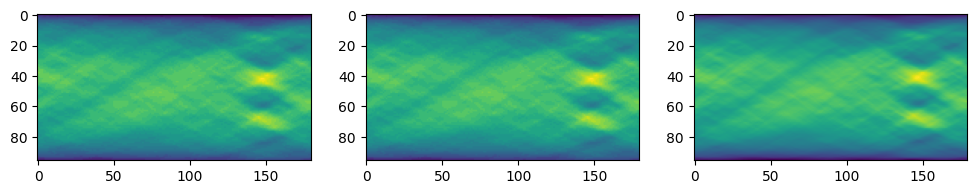

In [332]:
fig, axs = plt.subplots(ncols=3, figsize=(12,6))
axs[0].imshow(standard_result[1])
axs[1].imshow(batch_result[1])
axs[2].imshow(cv2_result[1][::-1,::-1])

(array([2000.,   27.,   92.,  508., 1385., 2297., 1824.,  766.,  275.,
          42.]),
 array([  0. ,  12.3,  24.6,  36.9,  49.2,  61.5,  73.8,  86.1,  98.4,
        110.7, 123. ]),
 <BarContainer object of 10 artists>)

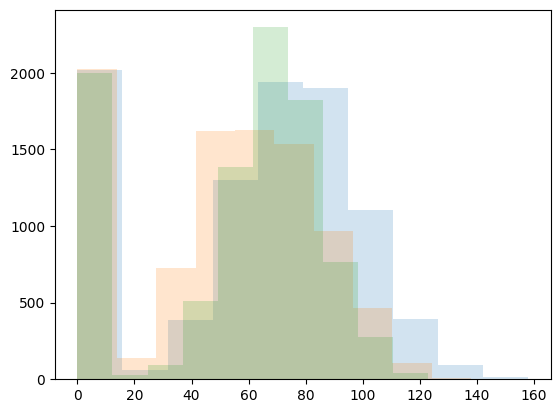

In [343]:
plt.hist(crops[10].flatten(), alpha=0.2)
plt.hist(crops[1].flatten(), alpha=0.2)
plt.hist(crops[8].flatten(), alpha=0.2)

In [355]:
def calculate_quantiles(batch, q=(0.1, 0.9)):
    return np.array([np.quantile(im[im!=0], q) for im in batch])

In [360]:
quantiles = calculate_quantiles(crops, (0.05, 0.95))

(array([ 6.,  6.,  6.,  5.,  5.,  6., 13.,  9.,  2.,  6.]),
 array([48. , 51.3, 54.6, 57.9, 61.2, 64.5, 67.8, 71.1, 74.4, 77.7, 81. ]),
 <BarContainer object of 10 artists>)

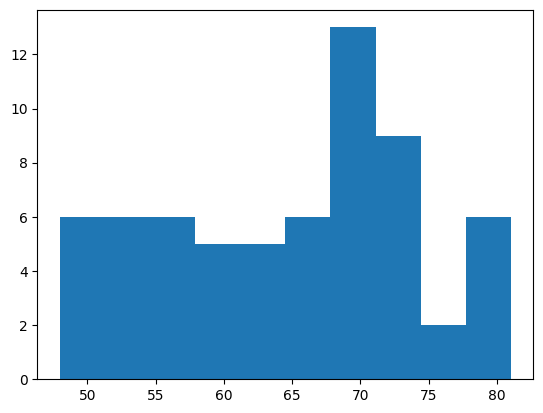

In [361]:
plt.hist(quantiles[:,1] - quantiles[:,0])

In [362]:
quantiles_diff = quantiles[:,1] - quantiles[:,0]

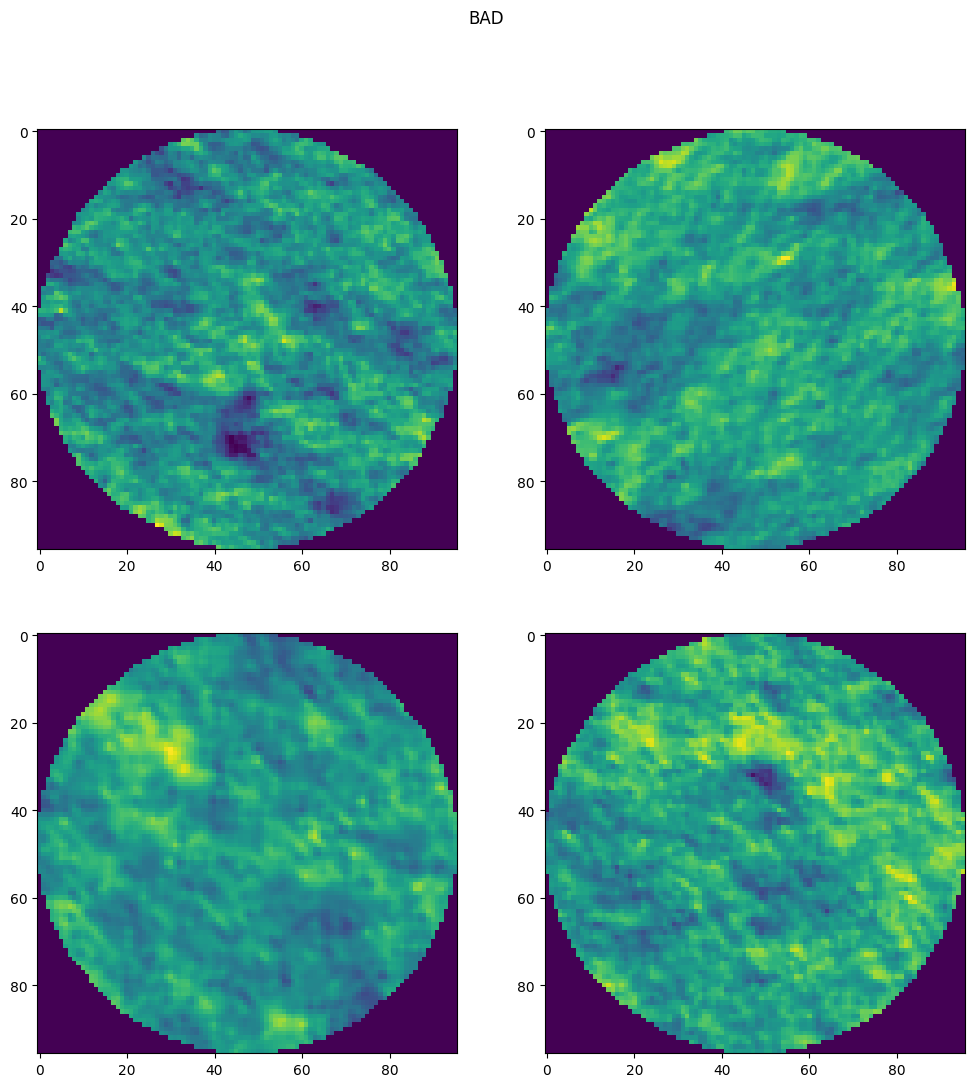

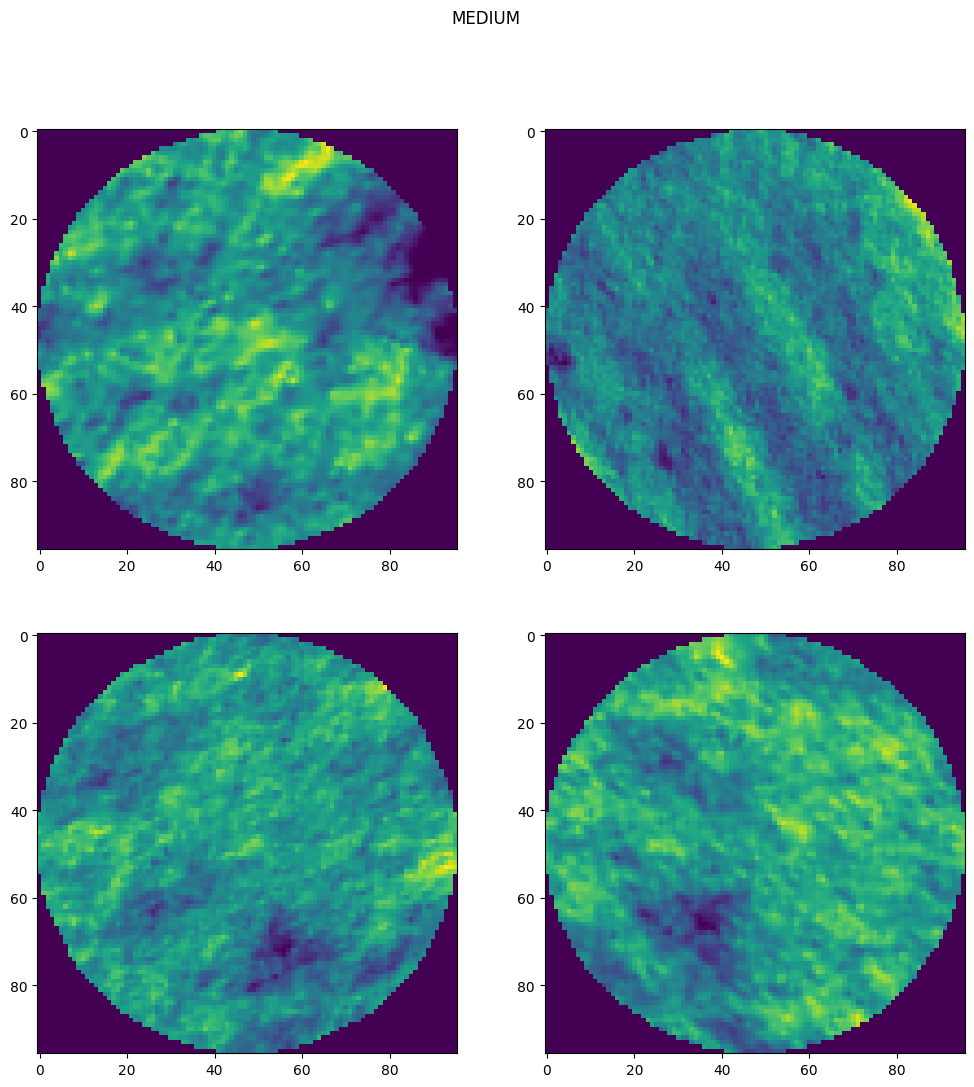

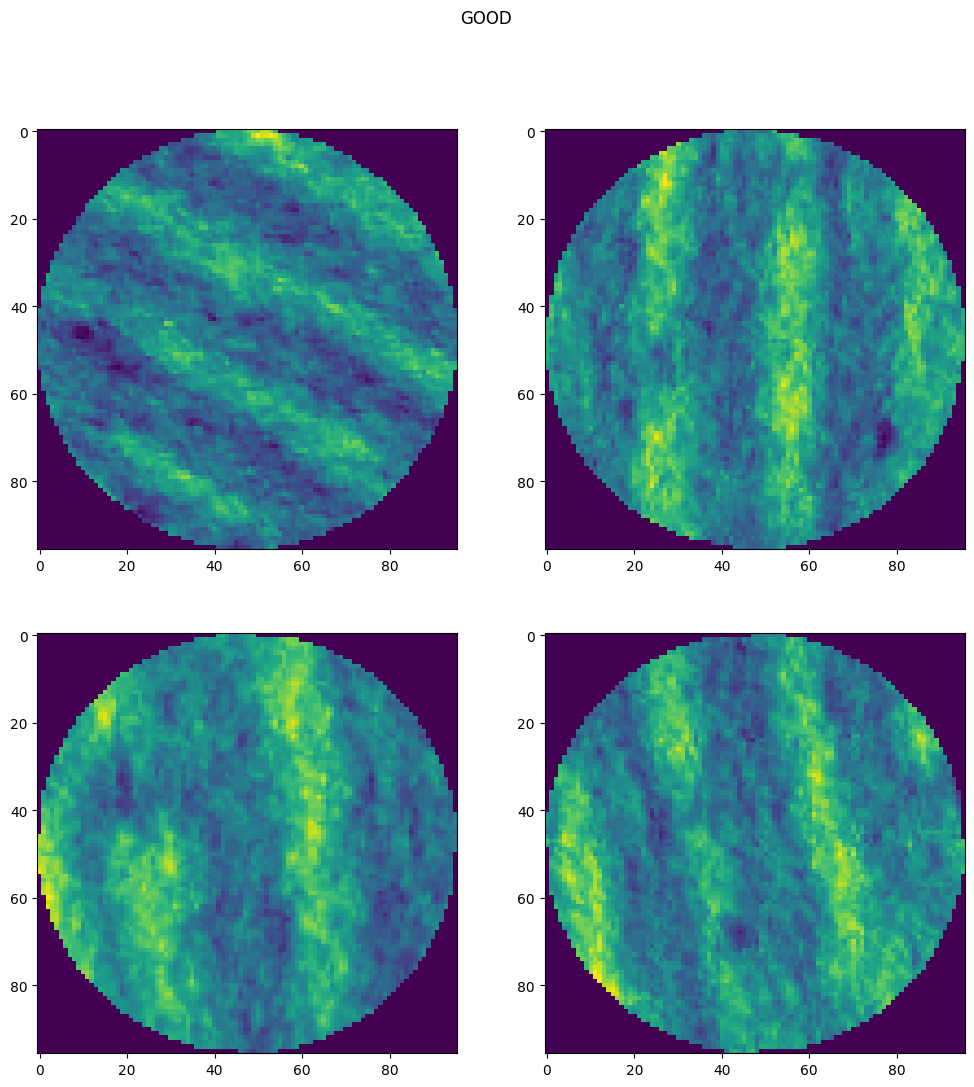

In [368]:
bad_thr, good_thr = np.quantile(quantiles_diff, (0.15, 0.85))
bad_indices =  np.random.choice(np.arange(len(crops))[quantiles_diff<=bad_thr], 4, replace=False)
medium_indices = np.random.choice(np.arange(len(crops))[(quantiles_diff>bad_thr)&(quantiles_diff<good_thr)], 4, replace=False)
good_indices =  np.random.choice(np.arange(len(crops))[quantiles_diff>=good_thr], 4, replace=False)

fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(12,12))
fig.suptitle('BAD')
for i, idx in enumerate(bad_indices):
    axs[i%2,i//2].imshow(crops[idx])

fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(12,12))
fig.suptitle('MEDIUM')
for i, idx in enumerate(medium_indices):
    axs[i%2,i//2].imshow(crops[idx])

fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(12,12))
fig.suptitle('GOOD')
for i, idx in enumerate(good_indices):
    axs[i%2,i//2].imshow(crops[idx])

(array([2.07210e+04, 3.89430e+04, 7.58000e+04, 1.24157e+05, 2.01587e+05,
        3.05419e+05, 2.78071e+05, 5.49580e+04, 5.96500e+03, 2.99000e+02]),
 array([ 0.17647059,  4.46352911,  8.75058842, 13.03764725, 17.32470512,
        21.61176491, 25.89882278, 30.18588257, 34.47294235, 38.75999832,
        43.04705811]),
 <BarContainer object of 10 artists>)

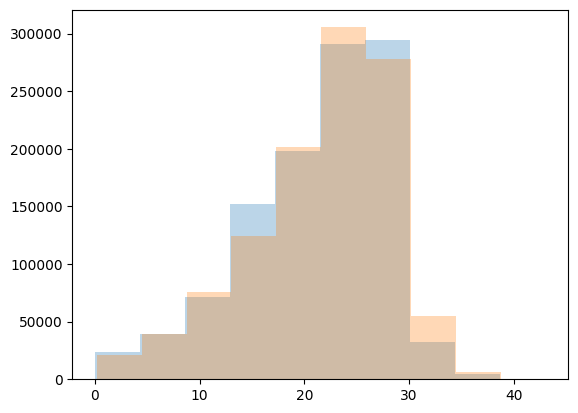

In [369]:
plt.hist(standard_result.flatten(), alpha=0.3)
plt.hist(cv2_result.flatten(), alpha=0.3)

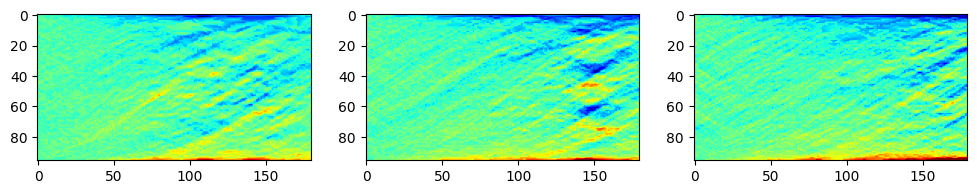

In [330]:
fig, axs = plt.subplots(ncols=3, figsize=(12,6))
for i in range(3):
    axs[i].imshow(standard_result[i]-cv2_result[i][::-1,::-1], cmap='jet', vmin=-5, vmax=5)


In [323]:
large_crops = np.concatenate((crops,crops,crops,crops, crops))

In [327]:
%timeit cv2_radonbatch(crops)

148 ms ± 31 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [328]:
%timeit cv2_radonbatch(large_crops)

796 ms ± 7.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
